In [1]:
import pandas as pd
from sklearn import metrics
import scipy
from scipy.sparse import csr_matrix
from scipy.sparse import csgraph
from scipy.sparse.csgraph import connected_components
from scipy.sparse.linalg import eigsh
import os
import matplotlib.colors as mcolors 
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from importlib import reload
import cooler

tool_path = "/home/cstansbu/miniconda3/lib/python3.9/site-packages/"
sys.path.append(tool_path)
import graph_tool.all as gt
print(f"{gt.__version__=}")

# locals 
import reconstruction as recon

sys.path.append("../")
import utils as ut
import plotting as plt2

/home/cstansbu/miniconda3/lib/python3.9/site-packages/graph_tool/draw/cairo_draw.py:32: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/cstansbu/miniconda3/lib/python3.9/site-packages/graph_tool/draw/cairo_draw.py:32: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/cstansbu/miniconda3/lib/python3.9/site-packages/graph_tool/draw/cairo_draw.py:32: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/cstansbu/miniconda3/lib/python3.9/site-packages/graph_tool/all.py:39: RuntimeWarning: Error importing draw module, proceeding nevertheless: No module named 'cairo._cairo'
  warnings.warn(msg, RuntimeWarning)


gt.__version__='2.58 (commit c513b9b6, )'
gt.__version__='2.58 (commit c513b9b6, )'


Ahic.shape=(196, 196)
Ahic.shape=(193, 193)


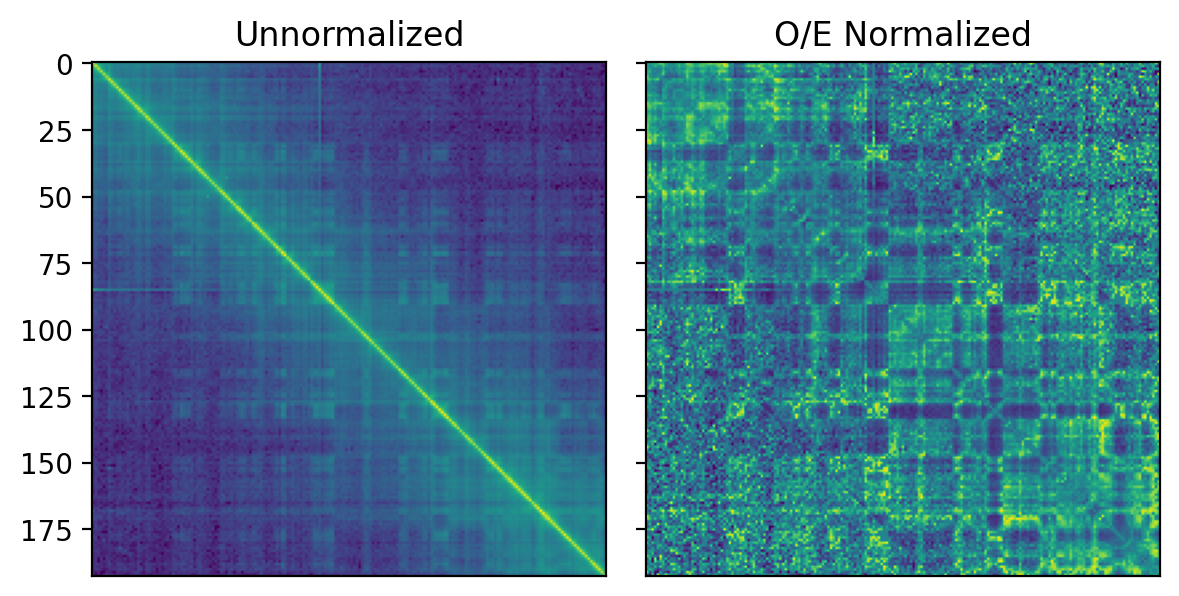

In [2]:
fpath = "/nfs/turbo/umms-indikar/shared/projects/poreC/data/f1219_population_hic/4DNFICF9PA9C.mcool"

resolution = 1000000

chrom = "chr1"
clr = cooler.Cooler(f'{fpath}::resolutions/{resolution}')
Ahic = clr.matrix(balance=False).fetch(str(chrom))[:]
Ahic = np.nan_to_num(Ahic)
print(f"{Ahic.shape=}")

# drop the telomere
Ahic = Ahic[3:, :][:, 3:]

print(f"{Ahic.shape=}")

# # remove artefact-bound indicies
# Ahic = ut.remove_indices(Ahic, [84, 85, 192])
# print(f"{Ahic.shape=}")

# balance and normalize 
Ahic_norm = ut.normalize_oe(ut.normalize_kr(Ahic).todense())

# correct outliers
top = 500
row_idx, col_idx = ut.get_sorted_upper_triangle_indices(Ahic_norm)

# update the matrix 
for i in range(top):
    Ahic_norm[row_idx[i], col_idx[i]] = Ahic_norm.mean()

# visualize
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 3
fig, axs = plt.subplots(1, 2, sharey=True)

axs[0].imshow(np.log1p(Ahic))
axs[1].imshow(Ahic_norm)

axs[0].set_title('Unnormalized')
axs[1].set_title('O/E Normalized')

axs[0].set_xticks([])
axs[1].set_xticks([])

plt.tight_layout()

In [3]:
# break

Input network thresholded at threshold=1.2 has 1 connected component(s)


<Graph object, undirected, with 193 vertices and 9938 edges, at 0x1482a0ac1d80>

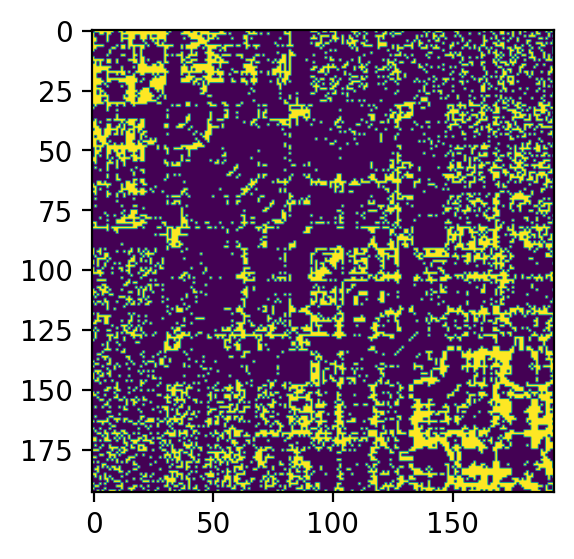

In [4]:
threshold = 1.2
Ahat = np.where(Ahic_norm > threshold, 1, 0)
num_components, _ = connected_components(Ahat, directed=False)
print(f"Input network thresholded at {threshold=} has {num_components} connected component(s)")

g = recon.create_graph_tools_from_adjacency(Ahat)

plt.imshow(Ahat)

g

In [5]:
hyperedges = recon.learn_hyperedges_mcmc(g, niter=100)
print(f"{len(hyperedges)=}")

len(hyperedges)=932


I.shape=(193, 932)


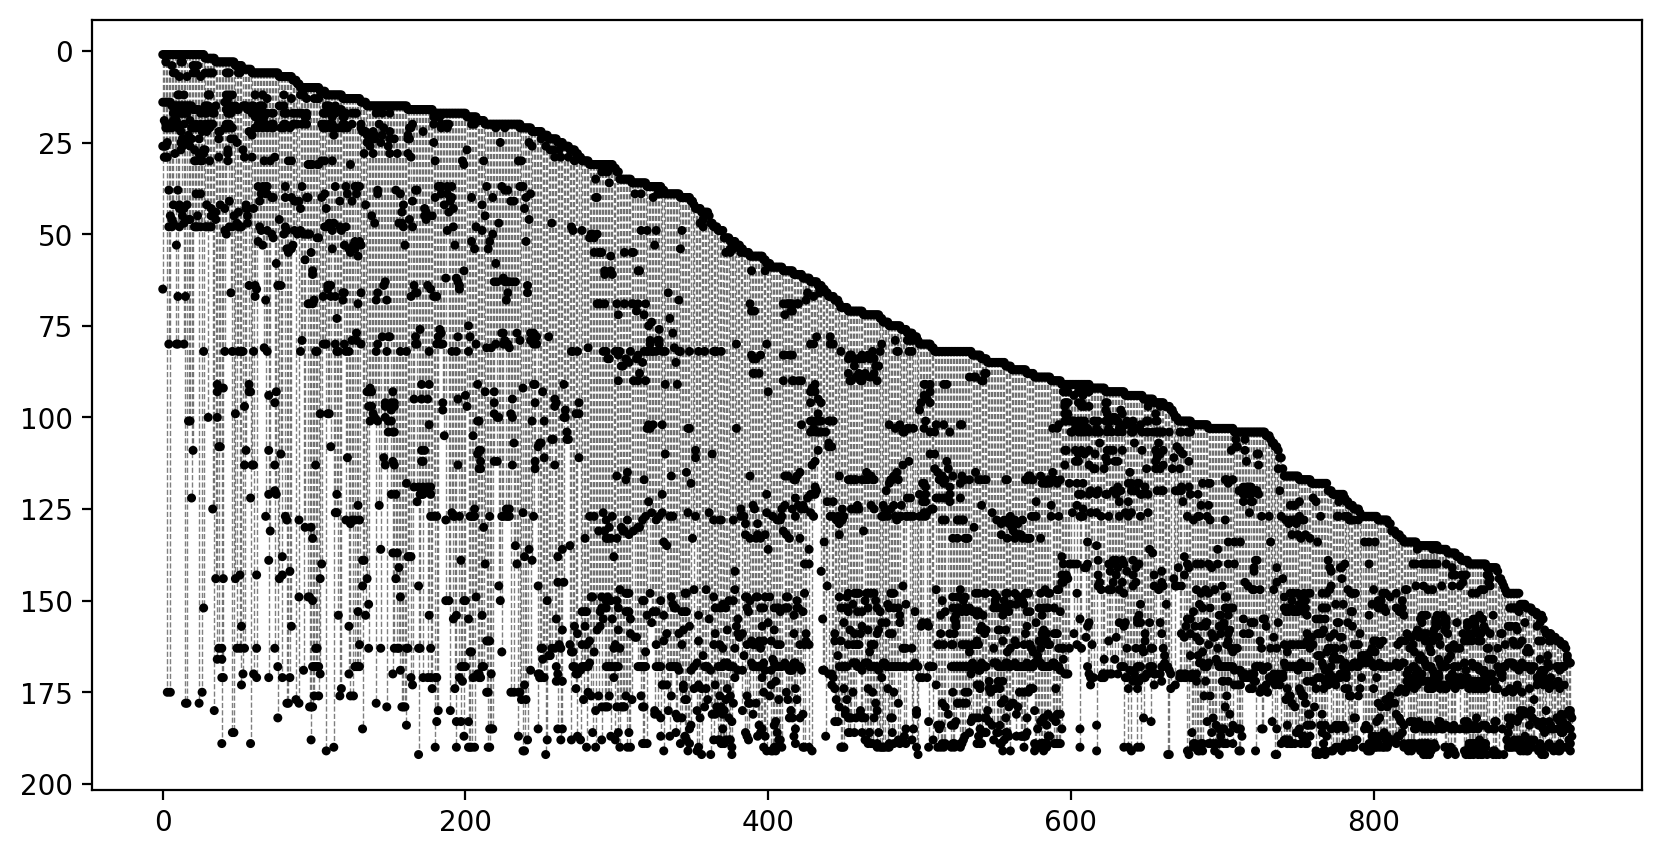

In [6]:
reload(ut)
I = ut.nested_list_to_incidence_matrix(hyperedges)
I = pd.DataFrame(I)
print(f"{I.shape=}")

node_params = {
    's' : 5,
    'ec' : 'k',
    'lw' : 1,
    'zorder' : 2,
}

line_params = {
    'lw' : 0.5,
    'alpha' : 0.5,
    'zorder' : 1,
    'ls' : '--',
}

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 10, 5
plt2.plot_incidence(ut.sort_by_lowest_index(I),
                    node_color='k',
                    node_params=node_params,
                    line_params=line_params)

degree.mean()=5.425965665236052
np.median(degree)=5.0


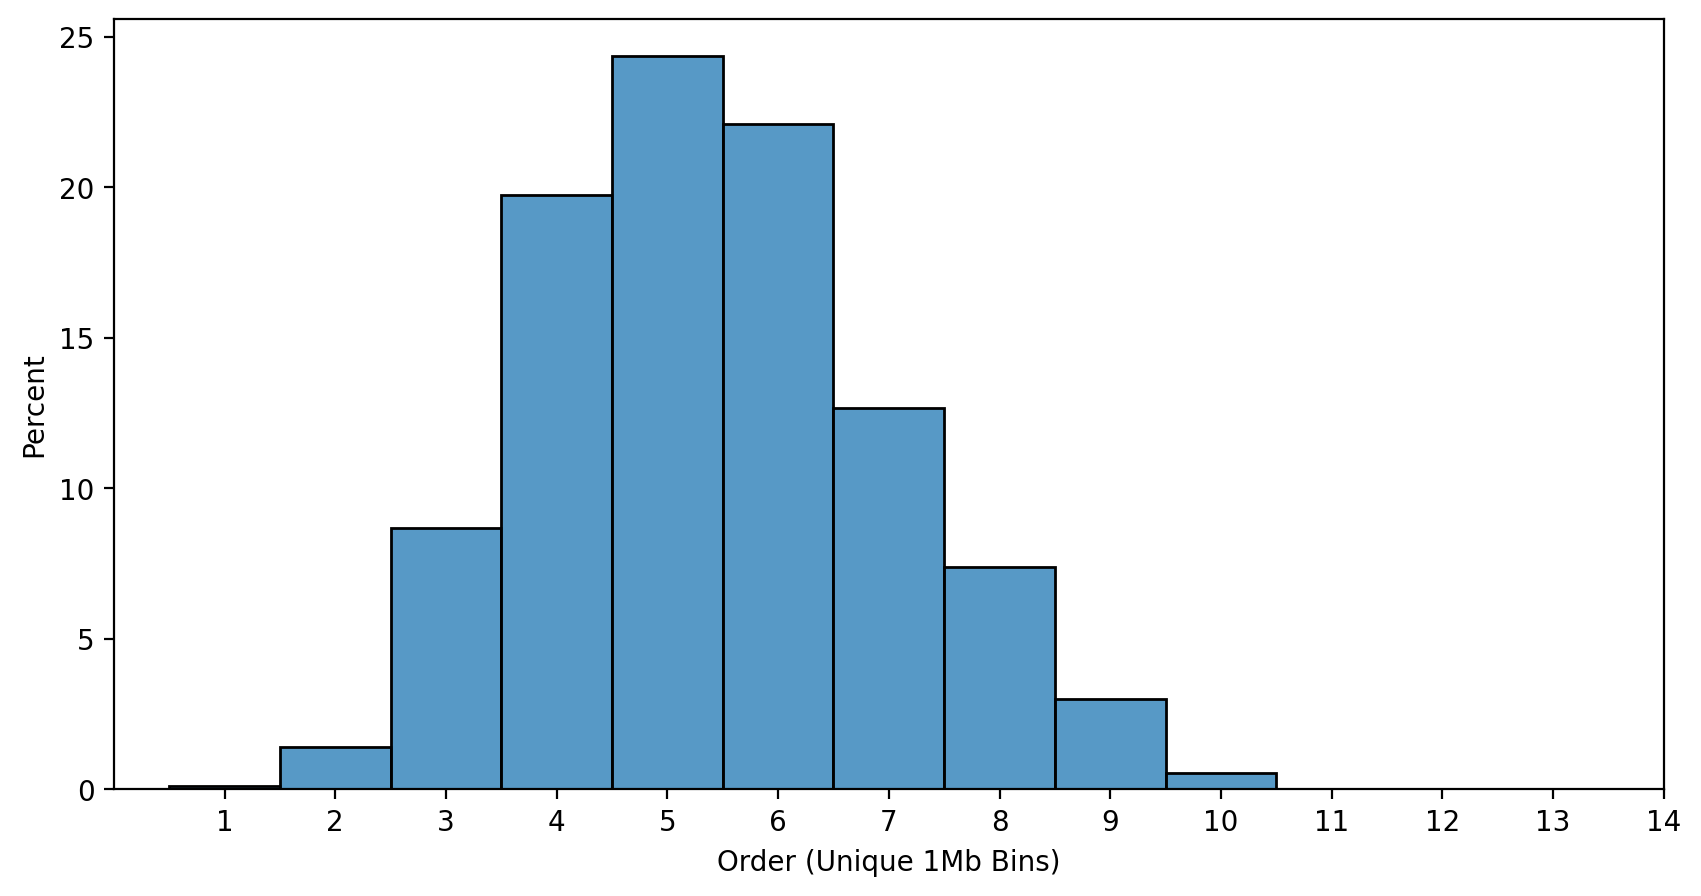

In [7]:
plt2.plot_incidence_order(I)

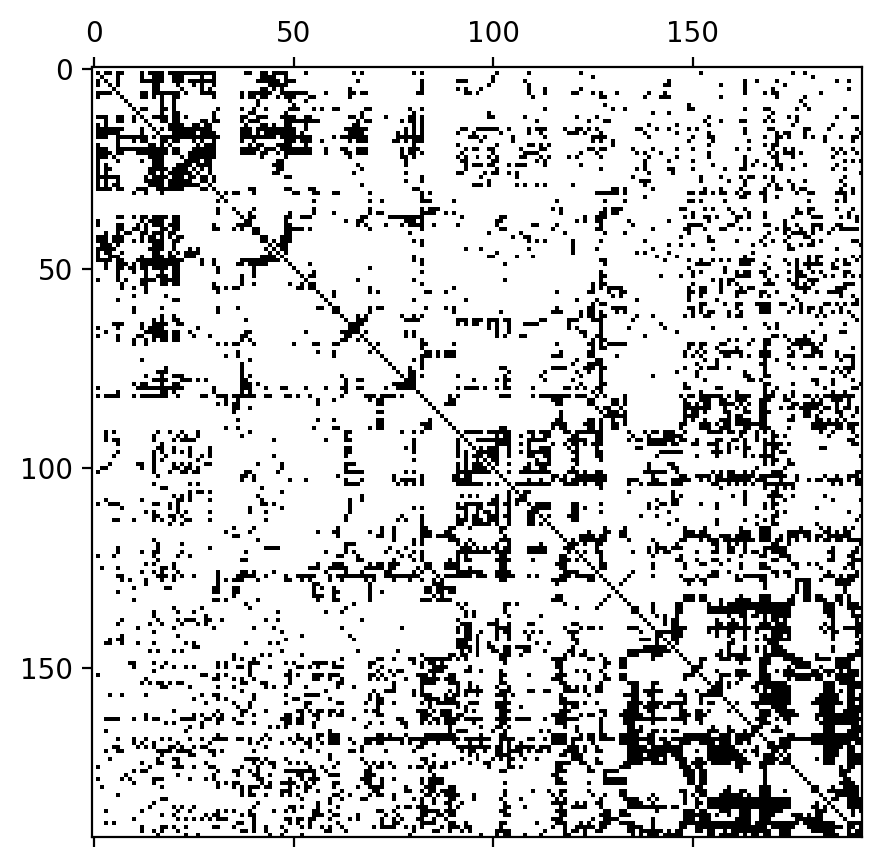

In [8]:
A_true = ut.clique_expand_incidence(I, zero_diag=False)
plt.spy(np.log1p(A_true))

In [9]:
outpath = "/nfs/turbo/umms-indikar/shared/projects/poreC/hypergraphs/population_reconstruction.csv"
I.to_csv(outpath)